# Model Comparison

Here we have the following models:
- 1 Conv layer with `Categorical Cross Entropy` loss function with `One Hot Encoding` of target
- 1 Conv layer with `Sparse Categorical Cross Entropy` loss function with `Sparse Encoding` of target

## Notebook Setup

In [57]:
import json
import logging
import mnist_data_load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential

In [58]:
enable_logging = True
if enable_logging:
    logging.getLogger().setLevel(logging.INFO)

In [59]:
random_seed = 100
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [60]:
assert len(tf.config.experimental.list_physical_devices('GPU')) == 1

In [142]:
class ModelDef:
    def __init__(self, name, model, layers, history, labels=None):
        self.name = name
        self.model = model
        self.labels = labels
        if labels is None:
            self.labels = {
                'loss': 'loss',
                'accuracy': 'accuracy'
            }
        self.layers = layers
        self.history = history
        self.interm_layers = []
        self.generate_intermeidate_layers()

    def get_history_for_label(self, label: str) -> list:
        if label in self.labels and self.labels[label] in self.history:
            return self.history[self.labels[label]]
        return None

    def add_label(self, label_key: str, label_value: str):
        self.labels[label_key] = label_value

    def generate_intermeidate_layers(self):
        for i in range(self.layers):
            model = Sequential()
            for j in range(i+1):
                model.add(self.model.layers[j])
            self.interm_layers.append(model)

    def predict(self, x):
        self.predictions = []
        for m in self.interm_layers:
            self.predictions.append(m.predict(x))
        return self.predictions

## Loading Models

In [143]:
models = []

In [144]:
model_one_hot = load_model('cnn_1x8_onehot.h5')
with open('cnn_1x8_onehot_training.json', 'r') as f:
    model_one_hot_training = json.loads(f.read())
mod_def = ModelDef(name='onehot_1x8', model=model_one_hot, layers=2, history=model_one_hot_training)
models.append(mod_def)

In [145]:
model_sparse = load_model('cnn_1x8_sparse.h5')
with open('cnn_1x8_sparse_training.json', 'r') as f:
    model_sparse_training = json.loads(f.read())
mod_def = ModelDef(name='sparse_1x8', model=model_sparse, layers=2, history=model_sparse_training, labels={'loss':'loss', 'accuracy': 'sparse_categorical_accuracy'})
models.append(mod_def)

## Load Model training history

## Comparing Models

### Model Training History

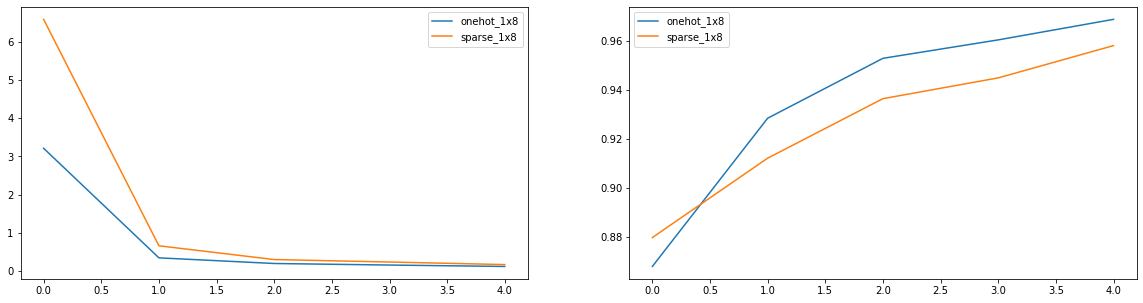

In [146]:
plt.figure(figsize=(20,5))
loss_plt = plt.subplot(1, 2, 1)
for i in range(len(models)):
    loss_plt.plot(models[i].get_history_for_label('loss'), label=models[i].name)
loss_plt.legend(loc='best')

accuracy_plt = plt.subplot(1, 2, 2)
for i in range(len(models)):
    accuracy_plt.plot(models[i].get_history_for_label('accuracy'), label=models[i].name)
accuracy_plt.legend(loc='best')
plt.show()

In [147]:
train_data, validation_data, test_data = mnist_data_load.load_data(seed=random_seed)

INFO:root:handling label: 1
INFO:root:handling label: 0
INFO:root:handling label: 4
INFO:root:handling label: 7
INFO:root:handling label: 3
INFO:root:handling label: 5
INFO:root:handling label: 8
INFO:root:handling label: 9
INFO:root:handling label: 2
INFO:root:handling label: 6


In [148]:
x_test, y_test = mnist_data_load.get_label_and_features_from_dataframe(test_data)

In [175]:
def show_interm_summary(layers):
    rand_index = np.random.randint(0, x_test.shape[0])
    rand_feat = x_test[rand_index]
    # make predictions
    for m in models:
        m.predict(rand_feat.reshape((1, 28, 28, 1)))
    # show the image on which we did prediction
    plt.imshow(rand_feat.reshape((28, 28)), cmap='gray')
    plt.show()
    # show each layer in separate plot
    for l in range(layers):
        fig = plt.figure(figsize=(10, 5), constrained_layout=True)
        grid = gridspec.GridSpec(2, 1, figure=fig)
        # plot weight
        # count the no of filters present -> tht many no of cols
        cols = min([w.shape[3] for m in models for l in m.model.layers for w in l.get_weights() if len(w.shape) == 4])
        rows = len(models)
        grid0 = grid[0].subgridspec(rows, cols)
        for m in models:
            layer = m.model.layers[l]
            plt.xlabel(layer.name)
            # if layer is a convolution layer
            if 'conv' in layer.name:
                wts = layer.get_weights()[0]
                for i in range(cols):
                    col = i
                    row = models.index(m)
                    subplt = fig.add_subplot(grid0[row, col])
                    subplt.imshow(wts[:, :, :, i].reshape((3, 3)), cmap='gray')
            # if layer is pooling layer
            elif 'pool' in layer.name:
                pass
        # plot prediction
        grid1 = grid[1].subgridspec(rows, cols)
        for m in models:
            output = m.predictions[l]
            for i in range(cols):
                col = i
                row = models.index(m)
                subplt = fig.add_subplot(grid1[row, col])
                subplt.imshow(output[0, :, :, i], cmap='gray')
        plt.show()

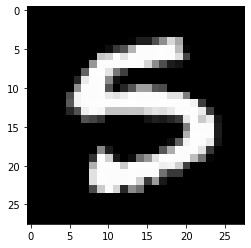

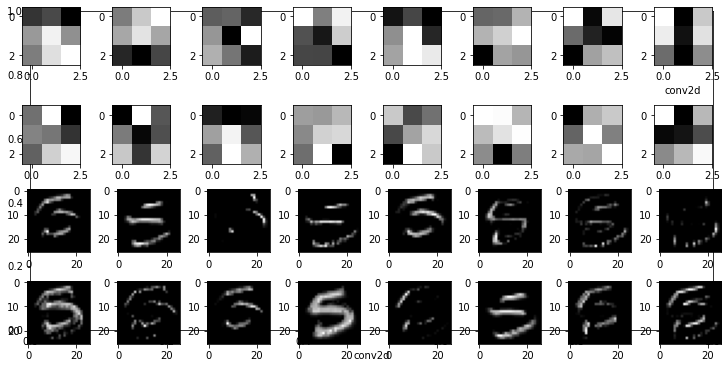

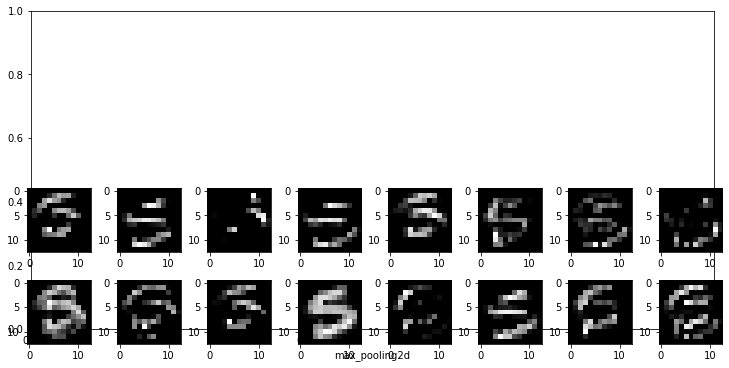

In [176]:
show_interm_summary(2)

## Observation

### One Hot vs Sparse

We can see that the accuracy differs by a small margin but both the models learned the same filters in 5 epochs and both have achieved the same loss by the end of 5th epoch

From this we can conclude that interchanging the loss function between `categorical_crossentropy` and `sparse_categorical_crossentropy` will not lead to mch difference except for the accuracy on the training set.